# Лабораторная работа №5

ФИО:   Стариков Александр Юрьевич  
Группа: БИВТ-23-СП-3  

Тема: Классификация изображений животных с помощью сверточной нейросети (PyTorch).


## 1. Загрузка и первичная организация данных

В этой части подключаем необходимые библиотеки, задаём устройство (`cpu`/`cuda`) и настраиваем путь до локального датасета с изображениями животных (`cheetah`, `leopard`, `lion`, `tiger`). Также выводим список папок, чтобы убедиться, что структура данных задана корректно.


In [ ]:
import os
import random

from PIL import Image

import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# красивые графики поменьше
plt.rcParams["figure.figsize"] = (6, 4)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Устройство:", device)

# Путь к данным относительно ноутбука
DATA_DIR = "..//date/animals"

print("Папки внутри DATA_DIR:", os.listdir(DATA_DIR))


Устройство: cpu
Папки внутри DATA_DIR: ['cheetah', 'leopard', 'lion', 'tiger']


## 2. Предобработка данных

Сделаем предобработку данных:

- Проверим битые файлы / повреждённые изображения и выведем их список (если такие есть).
- Приведём все изображения к единому размеру 224×224.
- Нормализуем изображения по каналам (стандарт для ImageNet: `mean=(0.485, 0.456, 0.406)`, `std=(0.229, 0.224, 0.225)`).
- Разделим выборку на обучающую и валидационную (train/val).
- Оформим данные в `ImageFolder` и передадим их в `DataLoader`.


In [4]:
# 1) Проверим, что все файлы читаются без ошибок
broken_files = []

for root, dirs, files in os.walk(DATA_DIR):
    for fname in files:
        fpath = os.path.join(root, fname)
        try:
            with Image.open(fpath) as img:
                img.verify()  # проверяем целостность
        except Exception as e:
            broken_files.append(fpath)

print("Найдено битых/повреждённых файлов:", len(broken_files))
if broken_files:
    print("Список битых файлов:")
    for bf in broken_files:
        print(" -", bf)

# 2) Задаём размер изображений и трансформации
img_size = 224  # приводим все изображения к 224×224

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# 3) Базовый датасет и разделение на train/val
base_dataset = datasets.ImageFolder(DATA_DIR)
class_names = base_dataset.classes
num_classes = len(class_names)
print("Классы:", class_names)
print("Всего изображений:", len(base_dataset))

indices = list(range(len(base_dataset)))
random.shuffle(indices)

train_size = int(0.8 * len(indices))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# 4) Датасеты с разными трансформациями
train_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=train_transform),
    train_indices,
)
val_dataset = Subset(
    datasets.ImageFolder(DATA_DIR, transform=val_transform),
    val_indices,
)

print(f"Размер train: {len(train_dataset)}, размер val: {len(val_dataset)}")

# 5) DataLoader'ы
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


Найдено битых/повреждённых файлов: 0
Классы: ['cheetah', 'leopard', 'lion', 'tiger']
Всего изображений: 731
Размер train: 584, размер val: 147


## 3. Постановка задачи и примеры изображений

**Задача:** многоклассовая классификация изображений животных (4 класса: `cheetah`, `leopard`, `lion`, `tiger`).  
**Объект:** фотография животного.  
**Цель:** по входному изображению определить, к какому из четырёх классов оно относится.

Ниже выведем несколько примеров изображений из обучающей выборки, чтобы визуально оценить данные и убедиться, что предобработка работает корректно.


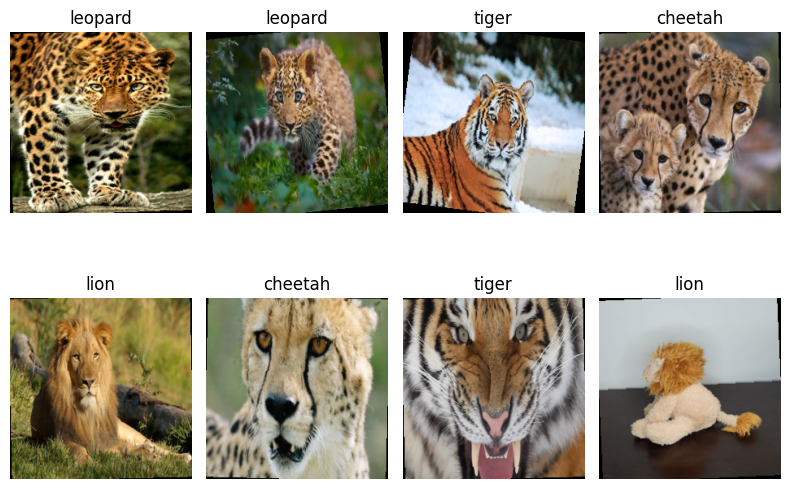

In [5]:
# Функция для обратного преобразования нормализации для отображения
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    return img

# Покажем несколько примеров из обучающей выборки
images, labels = next(iter(train_loader))

plt.figure(figsize=(8, 6))
for i in range(min(8, len(images))):
    plt.subplot(2, 4, i + 1)
    img = denormalize(images[i])
    plt.imshow(img)
    plt.title(class_names[labels[i].item()])
    plt.axis("off")
plt.tight_layout()
plt.show()


## 4. Разведочный анализ данных (EDA)

Посмотрим распределение количества изображений по классам в полной выборке. Это позволяет оценить возможный дисбаланс классов (например, если какого-то животного заметно меньше, чем остальных).


Количество изображений по классам:
cheetah: 186
leopard: 175
lion: 181
tiger: 189


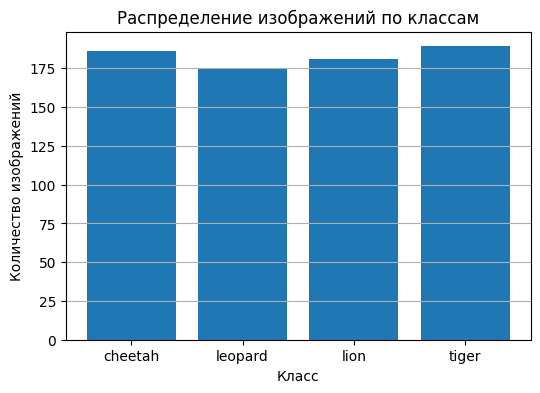

In [6]:
from collections import Counter

# Используем base_dataset, созданный на этапе предобработки
labels_all = [base_dataset.targets[i] for i in range(len(base_dataset))]
counter = Counter(labels_all)

print("Количество изображений по классам:")
for idx, cls_name in enumerate(class_names):
    print(f"{cls_name}: {counter.get(idx, 0)}")

# Визуализируем распределение
counts = [counter.get(i, 0) for i in range(len(class_names))]

plt.figure()
plt.bar(class_names, counts)
plt.xlabel("Класс")
plt.ylabel("Количество изображений")
plt.title("Распределение изображений по классам")
plt.grid(axis="y")
plt.show()


## 5. Аугментации изображений

Для улучшения обобщающей способности модели применяем простые аугментации в обучающей выборке: случайный поворот и горизонтальное отражение.  
Ниже визуализируем несколько аугментированных версий одного и того же исходного изображения.


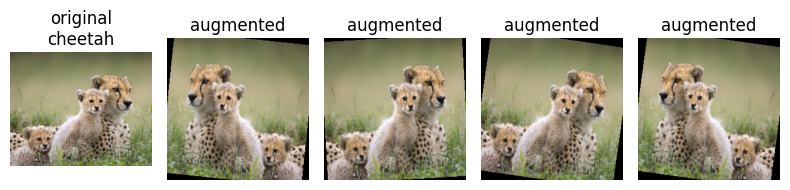

In [7]:
# Возьмём одно исходное изображение без трансформаций
pil_img, label_idx = base_dataset[0]

plt.figure(figsize=(8, 2))
plt.subplot(1, 5, 1)
plt.imshow(pil_img)
plt.title(f"original\n{class_names[label_idx]}")
plt.axis("off")

# Покажем несколько аугментированных версий через train_transform
for i in range(2, 6):
    aug_tensor = train_transform(pil_img)
    aug_img = denormalize(aug_tensor)
    plt.subplot(1, 5, i)
    plt.imshow(aug_img)
    plt.title("augmented")
    plt.axis("off")

plt.tight_layout()
plt.show()


## 6. Обучение модели (SimpleCNN для классификации животных)

In [8]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16
        )
        self.flatten = nn.Flatten()

        # Посчитаем количество признаков после свёрток на примере
        with torch.no_grad():
            dummy = torch.zeros(1, 3, img_size, img_size)
            feat = self.features(dummy)
            n_features = feat.view(1, -1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x


model = SimpleCNN(num_classes=num_classes, img_size=img_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Sequential(
    (0): Linear(in_features=50176, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)


## 7. Кривые обучения (loss и accuracy)

In [9]:
num_epochs = 10

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
}

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_correct += (preds == labels).sum().item()
        running_total += labels.size(0)

    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    model.eval()
    val_loss_sum = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss_sum += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss = val_loss_sum / val_total
    val_acc = val_correct / val_total

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:02d}/{num_epochs}: "
          f"train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
          f"train_acc={train_acc:.3f}, val_acc={val_acc:.3f}")


Epoch 01/10: train_loss=1.5709, val_loss=1.3475, train_acc=0.295, val_acc=0.320
Epoch 02/10: train_loss=1.2776, val_loss=1.2626, train_acc=0.380, val_acc=0.354
Epoch 03/10: train_loss=1.2109, val_loss=1.1178, train_acc=0.469, val_acc=0.524
Epoch 04/10: train_loss=1.0481, val_loss=0.9878, train_acc=0.553, val_acc=0.565
Epoch 05/10: train_loss=0.9186, val_loss=0.9144, train_acc=0.594, val_acc=0.626
Epoch 06/10: train_loss=0.8748, val_loss=0.9466, train_acc=0.625, val_acc=0.585
Epoch 07/10: train_loss=0.8150, val_loss=0.8751, train_acc=0.656, val_acc=0.639
Epoch 08/10: train_loss=0.7640, val_loss=0.9445, train_acc=0.661, val_acc=0.701
Epoch 09/10: train_loss=0.7771, val_loss=0.9118, train_acc=0.683, val_acc=0.612
Epoch 10/10: train_loss=0.7262, val_loss=0.8517, train_acc=0.712, val_acc=0.673


## 8. Метрики качества и оценка модели на валидационной выборке

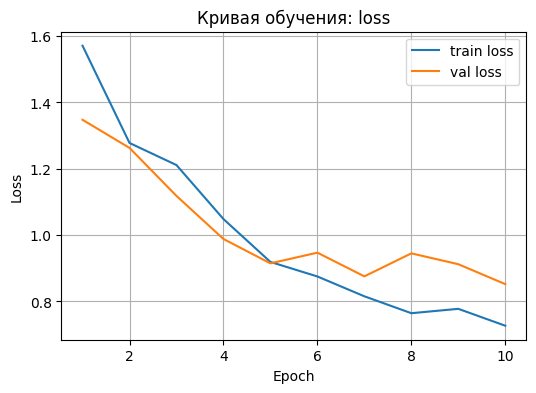

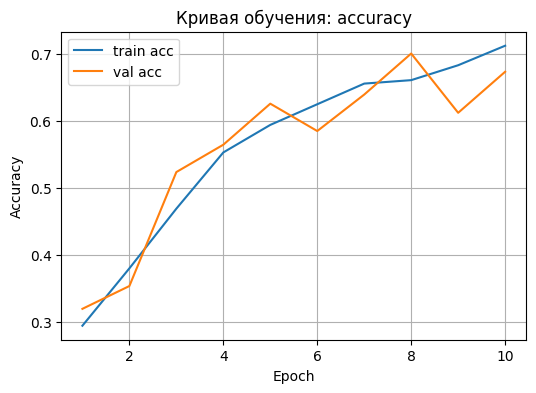

In [10]:
epochs = range(1, num_epochs + 1)

plt.figure()
plt.plot(epochs, history["train_loss"], label="train loss")
plt.plot(epochs, history["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Кривая обучения: loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(epochs, history["train_acc"], label="train acc")
plt.plot(epochs, history["val_acc"], label="val acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Кривая обучения: accuracy")
plt.legend()
plt.grid(True)
plt.show()


## 8. Метрики качества и оценка модели на валидационной выборке (classification report и confusion matrix)

In [11]:
model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

print("Confusion matrix:")
print(confusion_matrix(all_labels, all_preds))


Classification report:
              precision    recall  f1-score   support

     cheetah       0.75      0.46      0.57        39
     leopard       0.49      0.62      0.55        32
        lion       0.75      0.90      0.82        30
       tiger       0.74      0.74      0.74        46

    accuracy                           0.67       147
   macro avg       0.68      0.68      0.67       147
weighted avg       0.69      0.67      0.67       147

Confusion matrix:
[[18 10  9  2]
 [ 4 20  0  8]
 [ 1  0 27  2]
 [ 1 11  0 34]]


Какая модель лучше справилась?
В эксперименте использовалась одна модель — сверточная сеть SimpleCNN. На валидации она даёт accuracy ≈ 0.67, лучше всего распознаёт классы lion и tiger (у них самые высокие recall / f1-score).

Есть ли переобучение (по кривым обучения)?
Да, лёгкое переобучение есть: train_loss ниже val_loss, а train_accuracy заметно выше val_accuracy на последних эпохах, то есть модель лучше запоминает обучающую выборку, чем обобщает на валидации.

Какие классы путаются чаще всего и почему?
Чаще всего путаются cheetah ↔ leopard и leopard ↔ tiger (видно по матрице ошибок: много переходов между этими классами).
Причина — визуальное сходство: пятнистый окрас, похожая форма тела и позы, плюс фон/ракурс на фотографиях часто похожи.

Что ещё можно улучшить?
Усилить аугментации: random crop, color jitter, разные повороты/масштабы.
Попробовать более мощную архитектуру или transfer learning (например, ResNet с предобученными весами).
Поиграть с гиперпараметрами: learning rate, scheduler, число эпох, weight decay.
Собрать больше данных или выровнять классы (если дисбаланс усилится) и при необходимости ввести веса классов в функции потерь.

## 9. Визуализация предсказаний модели

Покажем несколько изображений из валидационной выборки вместе с предсказанным классом модели и истинной меткой.  
Корректные предсказания отметим `Y`, ошибочные — `N`.


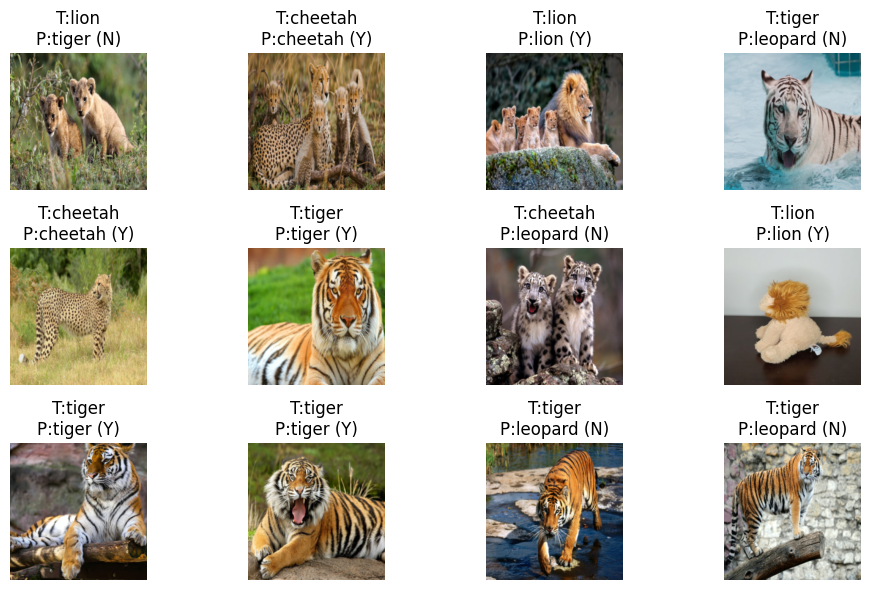

In [12]:
model.eval()

images, labels = next(iter(val_loader))
images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

plt.figure(figsize=(10, 6))
num_show = min(12, images.size(0))

for i in range(num_show):
    plt.subplot(3, 4, i + 1)
    img = denormalize(images[i].cpu())
    true_label = class_names[labels[i].item()]
    pred_label = class_names[preds[i].item()]
    mark = "Y" if true_label == pred_label else "N"
    plt.imshow(img)
    plt.title(f"T:{true_label}\nP:{pred_label} ({mark})")
    plt.axis("off")

plt.tight_layout()
plt.show()
